# import MNIST dataset

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import struct

In [33]:
mnist_data_folder = 'data/MNIST/'
mnist_train_images_file =  mnist_data_folder + f'train-images.idx3-ubyte'
mnist_train_labels_file =  mnist_data_folder + f'train-labels.idx1-ubyte'
mnist_test_images_file =  mnist_data_folder + f't10k-images.idx3-ubyte'
mnist_test_labels_file =  mnist_data_folder + f't10k-labels.idx1-ubyte'

# Reading from idx file function code snippet is taken from https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40#file-mnist-py
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

mnist_train_images = read_idx(mnist_train_images_file)
mnist_train_labels = read_idx(mnist_train_labels_file)
mnist_test_images = read_idx(mnist_test_images_file)
mnist_test_labels = read_idx(mnist_test_labels_file)

mnist_train_images.shape ,mnist_train_labels.shape,mnist_test_images.shape ,mnist_test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

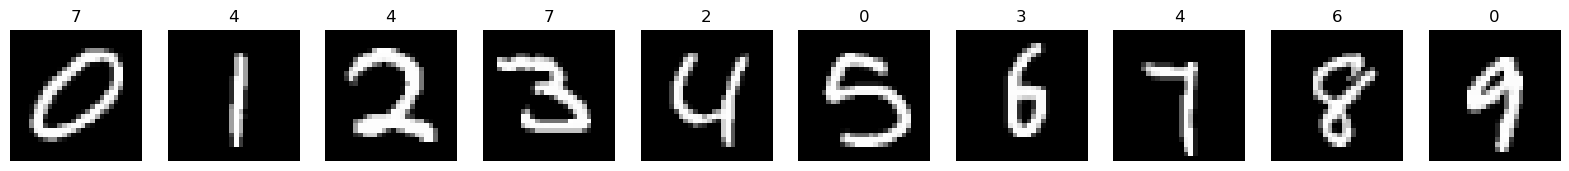

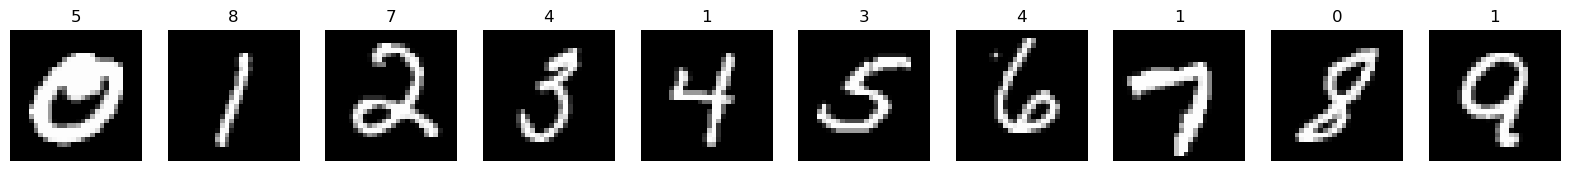

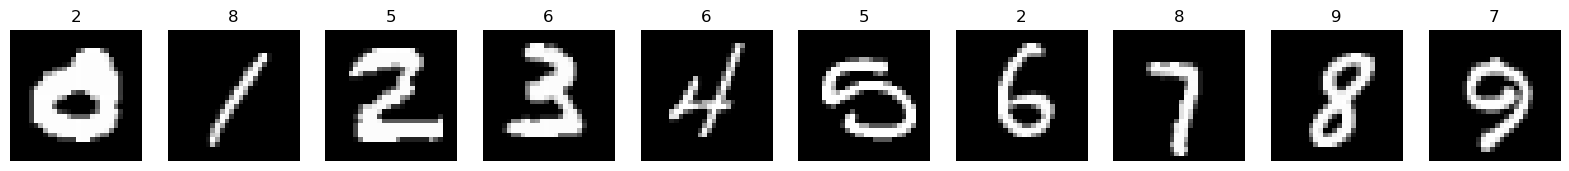

In [4]:
def plot_all_labels(images,labels):
    fig = plt.figure(figsize=(20,2))
    for i in range(10):
        ax = fig.add_subplot(1, 10, i+1)
        imgs = images[labels == i]
        img_i = np.random.randint(0, imgs.shape[0])
        ax.imshow(imgs[img_i], cmap='gray')
        ax.set_title(f'{labels[img_i]}')
        ax.axis('off')
    
plot_all_labels(mnist_train_images,mnist_train_labels)
plot_all_labels(mnist_train_images,mnist_train_labels)
plot_all_labels(mnist_train_images,mnist_train_labels)

## PCA 
from 784 to 392

In [34]:
def split_dataset(feats, targs, test_ratio = 0.2):
	n = feats.shape[0]
	test_size = int(n * test_ratio)
	mask = np.random.permutation(n)
	train_mask = mask[test_size:]
	test_mask = mask[:test_size]
	return feats[train_mask],  targs[train_mask], feats[test_mask] , targs[test_mask]

def calculate_corrcoef(original, reconstructed):
	x_bar = np.mean(original)
	y_bar = np.mean(reconstructed)
	num = np.sum((original - x_bar) * (reconstructed - y_bar))
	den = np.sqrt(np.sum((original - x_bar) ** 2) * np.sum((reconstructed - y_bar) ** 2))
	if den == 0:
		return 0
	return num / den

def calculate_mae(original, reconstructed):
	return np.mean(np.abs((original - reconstructed)))

def calculate_mse(original, reconstructed):
	return np.mean((original - reconstructed) ** 2)

def calculate_psnr(original, reconstructed, max_f = 255):
	mse = calculate_mse(original, reconstructed)
	if mse == 0:
		return 100 , mse
	psnr = 10 * np.log10( max_f**2 / mse) 
	return psnr , mse

def calculate_metrics(original, reconstructed):
	mae = calculate_mae(original, reconstructed)
	psnr, mse = calculate_psnr(original, reconstructed)
	return {'MAE' : mae , 'MSE' : mse , 'PSNR' : psnr}

def standardize_data(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std[std==0] = 1.0
    return X - mu / std , mu

def compute_pca_eigen(X, n_components):
	covariance_matrix = np.cov(X, rowvar=False)
	e_val, e_vec = np.linalg.eigh(covariance_matrix)
	e_sum = np.sum(e_val)

	mask = np.argsort(-e_val)
	e_val = e_val[mask]
	e_vec = e_vec[:, mask]
	
	principal_components = e_vec[:, :n_components]
	explained_variance = e_val[:n_components] / e_sum
	
	return principal_components , explained_variance

def reconstruct_images(X, components, mean):
	return np.dot(np.dot(X - mean, components), components.T) + mean

def plot_sample_compare(images_flat,reconstructed,n_components = None , Test_or_Train = None ,shape = (28,28),fixed_img  =None):
	if fixed_img :
		img = fixed_img
	else:
		img = np.random.choice(images_flat.shape[0])
	fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
	axes[0].imshow(images_flat[img].reshape(shape) ,cmap='gray')
	axes[0].set_title('Original')
	axes[0].axis('off')
	axes[1].imshow(reconstructed[img].reshape(shape), cmap='gray')
	axes[1].set_title('Constructed')
	axes[1].axis('off')
	plt.axis('off')
	if n_components:
		fig.suptitle( str(Test_or_Train) + ' $N_{components}$ = ' + str(n_components))
		
def PCA(train_images , test_images ,n_components,plt = None ,shape = (28,28),fixed_img = None):
	train_centered, train_mean = standardize_data(train_images)
	test_centered, test_mean = standardize_data(test_images)
	principal_components, var = compute_pca_eigen(train_centered, n_components)
	
	explained_var = var #/ np.sum(var) 

	train_reconstructed = reconstruct_images(train_centered, principal_components, train_mean)
	test_reconstructed = reconstruct_images(test_centered, principal_components,test_mean)
	if plt :
		plot_sample_compare(train_images,train_reconstructed,n_components,'Train Data : ',shape, fixed_img =fixed_img )
		plot_sample_compare(test_images,test_reconstructed,n_components,'Test Data : ',shape,fixed_img =fixed_img  )
	
	return train_reconstructed, test_reconstructed, explained_var

def PCA_reduce(train_images, test_images, n_components):
    train_centered, train_mean = standardize_data(train_images)
    test_centered, test_mean = standardize_data(test_images)
    principal_components, var = compute_pca_eigen(train_centered, n_components)
    train_reduced = np.dot(train_centered, principal_components)
    test_reduced = np.dot(test_centered, principal_components)  

    return train_reduced, test_reduced


In [35]:
# flatten the imgs
mnist_train_images_flat = mnist_train_images.reshape(-1, 28 * 28)
mnist_test_images_flat = mnist_test_images.reshape(-1, 28 * 28)

# n_comps
mnist_n_components = 392

### PCA on validation data

In [60]:
def k_fold_cross_validation(X, k, model = PCA, n_components = 392):
	mask = np.arange(X.shape[0])
	np.random.shuffle(mask)
	X = X[mask]
	splits = np.array_split(X, k)
	train_metrics = []
	test_metrics = []
	for i in range(k):
		train = np.concatenate([splits[j] for j in range(k) if j != i])
		test = splits[i]
		train_reconstructed, test_reconstructed, explained_variance = model(train, test, n_components)
		train_metrics.append(calculate_metrics(train, train_reconstructed))
		test_metrics.append(calculate_metrics(test, test_reconstructed))
	
	return train_metrics, test_metrics

train_metrics, test_metrics = k_fold_cross_validation(mnist_train_images_flat, 5)

In [61]:
print(f'{mnist_n_components} components')
train_m = []
metrics = ['MAE', 'MSE', 'PSNR']
for metric in metrics:
    train_m.append(np.array([m[metric] for m in train_metrics]).mean())
for m,v in zip(metrics,train_m):
    print(f'Train {m} : {v}')
test_m = []
metrics = ['MAE', 'MSE', 'PSNR']
for metric in metrics:
    test_m.append(np.array([m[metric] for m in test_metrics]).mean())
for m,v in zip(metrics,test_m):
    print(f'Test {m} : {v}')

392 components
Train MAE : 1.7457052132288808
Train MSE : 20.66548583161251
Train PSNR : 34.97836997828054
Test MAE : 1.7663151252779052
Test MSE : 21.293559413916526
Test PSNR : 34.84867595636331


In [ ]:
n = mnist_test_images_flat.shape[1]
splits = 4
n_comps = range(n//splits,n+1,n//splits)
for n_comp in n_comps:
    train_metrics, test_metrics = k_fold_cross_validation(mnist_train_images_flat, k=5, n_components=n_comp)
    print(f'{n_comp = }')
    metrics = ['MSE']
    train_m = []
    for metric in metrics:
        train_m.append(np.array([m[metric] for m in train_metrics]).mean())
    for m,v in zip(metrics,train_m):
        print(f'Train {m} : {v}')
    test_m = []
    for metric in metrics:
        test_m.append(np.array([m[metric] for m in test_metrics]).mean())
    for m,v in zip(metrics,test_m):
        print(f'Test {m} : {v}')
    print('----------------------------------')

n_comp = 392
Train MSE : 20.666620575561655
Test MSE : 21.283161697620464
----------------------------------
n_comp = 784
Train MSE : 0.26463831884176936
Test MSE : 0.2646777628869474
----------------------------------


In [63]:
mnist_train_reconstructed, mnist_test_reconstructed = PCA_reduce(mnist_train_images_flat, mnist_test_images_flat, mnist_n_components)
mnist_train_reconstructed.shape, mnist_test_reconstructed.shape

((60000, 392), (10000, 392))

In [72]:
#export reconstructed
np.save(mnist_data_folder + 'X_train.npy', mnist_train_reconstructed)
np.save(mnist_data_folder + 'X_test.npy', mnist_test_reconstructed)
np.save(mnist_data_folder + 'y_test.npy', mnist_test_labels)
np.save(mnist_data_folder + 'y_train.npy', mnist_train_labels)

# Load MNIST PCA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct

mnist_data_folder = 'data/MNIST/'
mnist_train_images_file =  mnist_data_folder + f'train-images.idx3-ubyte'
mnist_train_labels_file =  mnist_data_folder + f'train-labels.idx1-ubyte'
mnist_test_images_file =  mnist_data_folder + f't10k-images.idx3-ubyte'
mnist_test_labels_file =  mnist_data_folder + f't10k-labels.idx1-ubyte'

# Reading from idx file function code snippet is taken from https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40#file-mnist-py
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

mnist_train_images = read_idx(mnist_train_images_file)
mnist_train_labels = read_idx(mnist_train_labels_file)
mnist_test_images = read_idx(mnist_test_images_file)
mnist_test_labels = read_idx(mnist_test_labels_file)

mnist_train_images.shape ,mnist_train_labels.shape,mnist_test_images.shape ,mnist_test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [2]:
X_train = np.load(mnist_data_folder + 'X_train.npy')
X_test = np.load(mnist_data_folder + 'X_test.npy')
y_test = np.load(mnist_data_folder + 'y_test.npy')
y_train = np.load(mnist_data_folder + 'y_train.npy')
X_train.shape, X_test.shape, y_test.shape, y_train.shape

((60000, 392), (10000, 392), (10000,), (60000,))

# KNN 

## Built IN

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


knn = KNeighborsClassifier(n_neighbors=3) 
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on reduced data (PCA): {accuracy:.4f}")
print(f'Test Error Rate on reduced data (PCA): {(1 - accuracy)*100:.2f}%')

KNeighborsClassifier(n_neighbors=3)

Accuracy on reduced data (PCA): 0.9706
Test Error Rate on reduced data (PCA): 2.94%


## My implementation

##### for k = 3

In [ ]:
from knnClassification import KNearestN_Classifier 
knn = KNearestN_Classifier(k=3)
knn.fit(X_train, y_train)

# y_pred = knn.predict(X_test)

# [LOG] > Time Taken : 27m 3.7s

In [5]:
# np.save(mnist_data_folder + 'y_pred_mine_knn_k3.npy', y_pred)

In [6]:
y_pred = np.load(mnist_data_folder + 'y_pred_mine_knn_k3.npy')

In [7]:
accuracy = knn.acc_score(y_test, y_pred)
print(f"Accuracy on original data: {accuracy:.4f}")
print(f'Test Error Rate on reduced data (PCA): {1 - accuracy:.4f}')

Accuracy on original data: 0.9706
Test Error Rate on reduced data (PCA): 0.0294


##### for k = 5

In [ ]:
from knnClassification import KNearestN_Classifier 
knn = KNearestN_Classifier(k=5)
knn.fit(X_train, y_train)

# y_pred = knn.predict(X_test)
# np.save(mnist_data_folder + 'y_pred_mine_knn_k5.npy', y_pred)
y_pred = np.load(mnist_data_folder + 'y_pred_mine_knn_k5.npy')

accuracy = knn.acc_score(y_test, y_pred)
print(f"Accuracy on original data: {accuracy:.4f}")
print(f'Test Error Rate on reduced data (PCA): {1 - accuracy:.4f}')
# [LOG] > Time Taken : 27m 3.7s

Accuracy on original data: 0.9688
Test Error Rate on reduced data (PCA): 0.0312


In [23]:
def compare_with_images(model, X_test, y_test, mnist_test , lables = 10):
    fig = plt.figure(figsize=(20,2))
    for i in range(10):
        ax = fig.add_subplot(1, lables, i+1)
        imgs = mnist_test[y_test == i]
        pred = X_test[y_test == i]
        lbls = y_test[y_test == i]
        img_i = np.random.randint(0, imgs.shape[0])
        model_pred = model.predict(pred[img_i].reshape(1,-1))
        ax.imshow(imgs[img_i], cmap='gray')
        if model_pred[0] == lbls[img_i]:
            ax.set_title(f'Actual :{lbls[img_i]} \nPredict :{int(model_pred[0])} \nimage:', color='green')
        else:
            ax.set_title(f'Actual :{lbls[img_i]} \nPredict :{int(model_pred[0])} $\\times$ \nimage:', color='red')
        # ax.set_title(f'Actual :{lbls[img_i]} \nPredict :{int(model_pred[0])}\nReconstructing:')
        ax.axis('off')


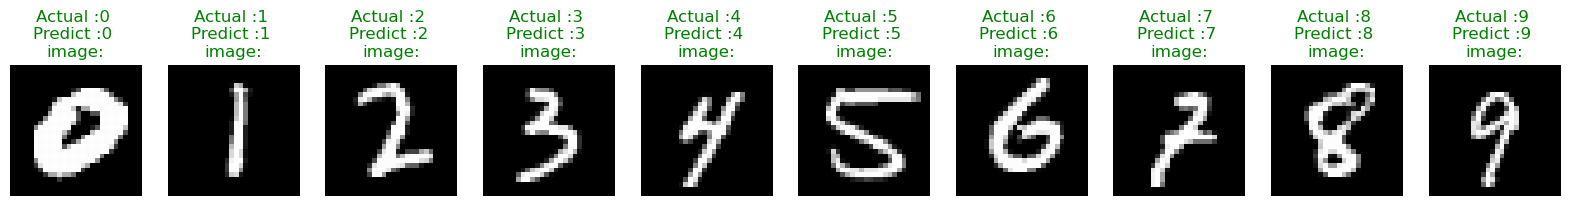

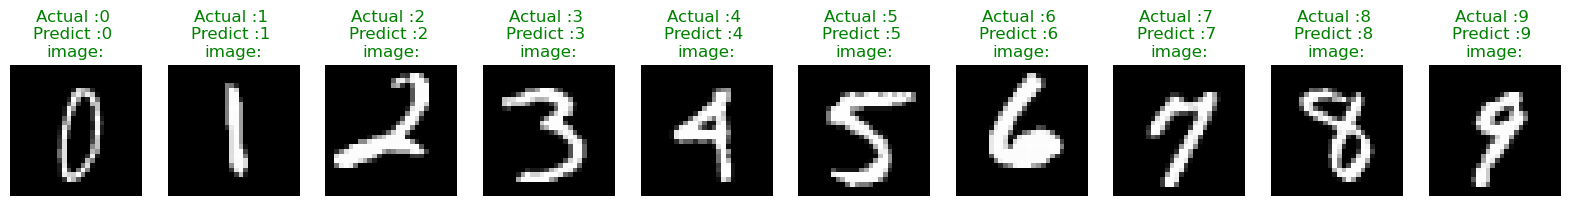

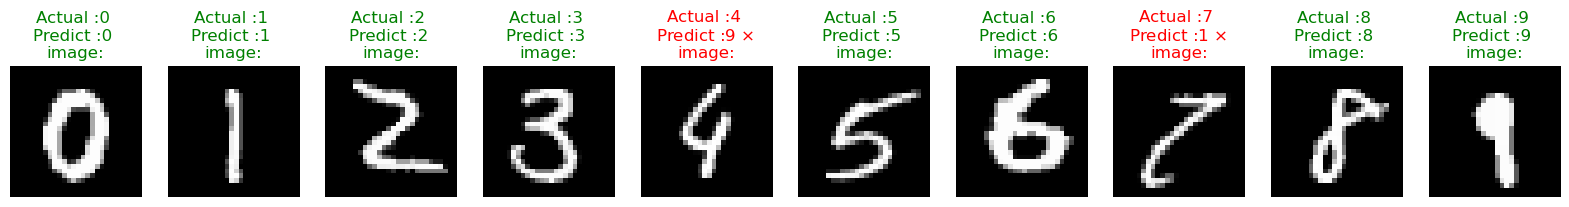

In [28]:
compare_with_images(knn, X_test, y_test, mnist_test_images)
compare_with_images(knn, X_test, y_test, mnist_test_images)
compare_with_images(knn, X_test, y_test, mnist_test_images)

# Naive Bayes

## Built IN


In [10]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_nb = gnb.predict(X_test)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy using Naive Bayes: {accuracy_nb:.4f}")
print(f'Test Error Rate using Naive Bayes: {(1 - accuracy_nb)*100:.2f}%')

GaussianNB()

Accuracy using Naive Bayes: 0.7630
Test Error Rate using Naive Bayes: 23.70%


## My implementation

In [ ]:
from naiveBayesClassification import NaiveBayes

nb = NaiveBayes()
nb.fit(X_train, y_train,alpha=1e-9)
y_pred = nb.predict(X_test)

In [12]:
accuracy = nb.acc_score(y_test, y_pred)
print(f"Accuracy using Naive Bayes: {accuracy:.4f}")
print(f'Test Error Rate using Naive Bayes: {(1 - accuracy) *100:.2f}')

Accuracy using Naive Bayes: 0.4410
Test Error Rate using Naive Bayes: 55.90


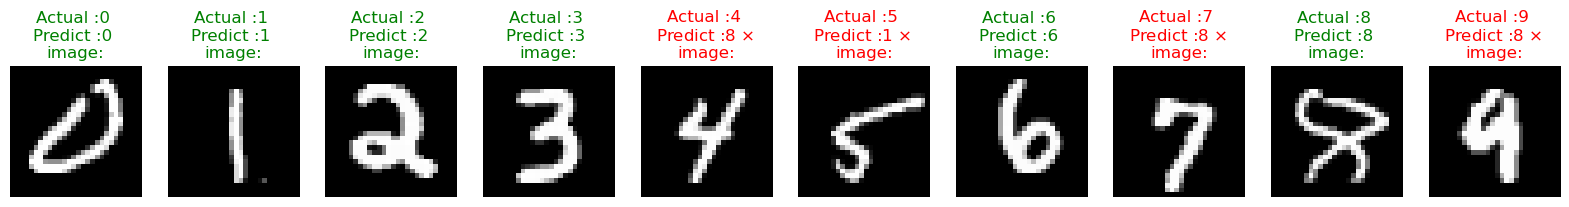

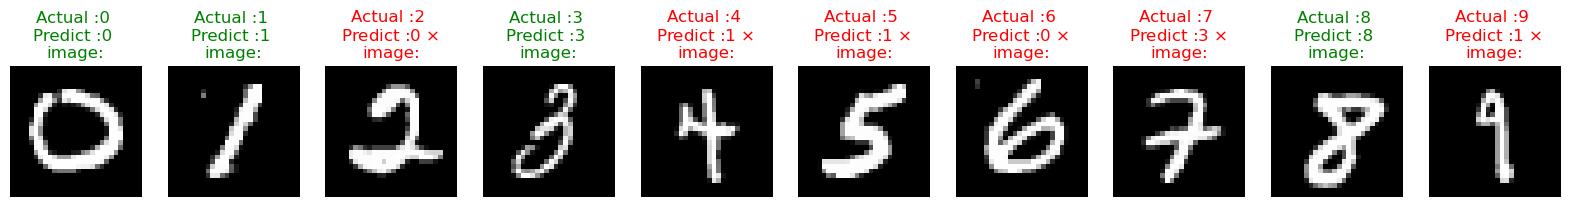

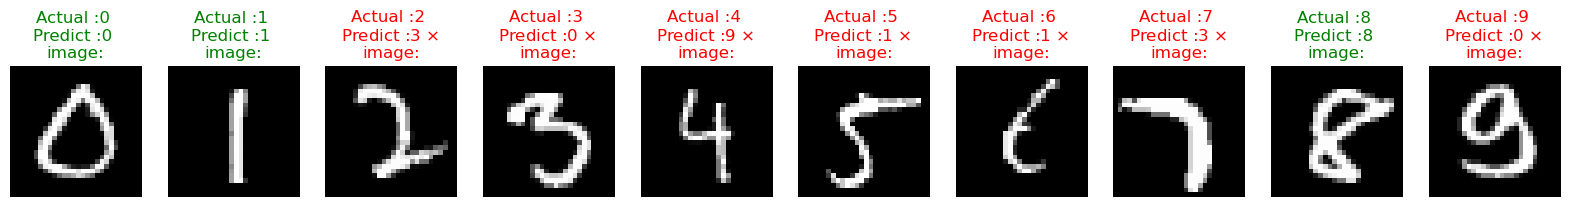

In [30]:
compare_with_images(nb, X_test, y_test, mnist_test_images)
compare_with_images(nb, X_test, y_test, mnist_test_images)
compare_with_images(nb, X_test, y_test, mnist_test_images)

# Logistic Regression

## Built IN

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy using Logistic Regression: {accuracy_lr:.4f}")
print(f'Test Error Rate using Logistic Regression: {(1 - accuracy_lr)*100:.2f}%')

c:\Users\myalla\anaconda3\envs\iisc\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

Accuracy using Logistic Regression: 0.9216
Test Error Rate using Logistic Regression: 7.84%


## My Implementation

In [ ]:
from logisticRegressionClassification import LogisticRegression_Classifier

lr  = LogisticRegression_Classifier(
    alpha = 0.01,
    stochastic=True,
    stochastic_choice= 1000
)


In [36]:
# lr.fit(X_train, y_train)

In [37]:
# y_pred = lr.predict(X_test)